## Question2

## Loading libraries:

In [2]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [3]:
from spacy.cli.download import download
download(model="en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
%matplotlib inline
import pandas as pd, numpy as np, os, pickle
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np, pandas as pd, os
import gensim
import logging
import spacy
from scipy import spatial
from sklearn.decomposition import LatentDirichletAllocation
# configure logger. Can be logging.Info or logging.Error to control printouts during training
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR) 

root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('C:\\Users\\Majdal\\Desktop\\MBA\\machine learning\\assignment#2')

In [2]:
os.getcwd()

'C:\\Users\\Majdal\\Desktop\\MBA\\machine learning\\assignment#2'

## Loading Data:

In [3]:
import zipfile

books_file_name = os.path.join(data_folder, 'Books.zip')
os.getcwd()
path='C:\\Users\\Majdal\\Desktop\\MBA\\machine learning\\assignment#2\\Books.zip'

In [4]:
import csv
from io import TextIOWrapper
from zipfile import ZipFile
books=[]
with ZipFile(path ) as zf:
    with zf.open('books.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'))
        for row in reader:
            # process the CSV here
            books.append(row)
         

In [5]:
df_books = pd.DataFrame (books)
header = df_books.iloc[0]
df_books.drop([0], axis =0, inplace=True)
df_books.reset_index(drop=True)
df_books.columns = header
df_books.head()

,book_id,authors,original_publication_year,original_title,language_code
1,0,Suzanne Collins,2008.0,The Hunger Games,eng
2,1,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng
3,2,Stephenie Meyer,2005.0,Twilight,en-US
4,3,Harper Lee,1960.0,To Kill a Mockingbird,eng
5,4,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng


In [6]:
ratings=[]
with ZipFile(path) as zf:
    with zf.open('ratings.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'))
        for row in reader:
            # process the CSV here
            ratings.append(row)


In [7]:
df_ratings = pd.DataFrame (ratings)
header = df_ratings.iloc[0]
df_ratings.drop([0], axis =0, inplace=True)
df_ratings.reset_index(drop=True)
df_ratings.columns = header
df_ratings.tail()

,user_id,book_id,rating
5976475,49924,509,5
5976476,49924,527,4
5976477,49924,721,4
5976478,49924,948,5
5976479,49924,1022,4


In [8]:
df_ratings['user_id'].nunique()

53424

## Merge books data set with ratings data set by book_id:

In [9]:
book_user_rating = df_books.merge(df_ratings, left_on = 'book_id',right_on = 'book_id')
book_user_rating = book_user_rating[['book_id',  'authors','original_title','user_id', 'rating']]
book_user_rating.reset_index(drop=True, inplace = True)

In [10]:
book_user_rating.head()

,book_id,authors,original_title,user_id,rating
0,0,Suzanne Collins,The Hunger Games,2885,5
1,0,Suzanne Collins,The Hunger Games,6157,5
2,0,Suzanne Collins,The Hunger Games,3990,4
3,0,Suzanne Collins,The Hunger Games,5280,5
4,0,Suzanne Collins,The Hunger Games,5720,5


In [13]:
book_user_rating.shape

(5976479, 5)

In [14]:
book_user_rating.isnull().count()

0
book_id           5976479
authors           5976479
original_title    5976479
user_id           5976479
rating            5976479
dtype: int64

## Creating sparse matrix:

In [15]:
book_pivot = book_user_rating.pivot_table(columns="user_id", index="book_id", values="rating")

In [16]:
book_pivot.shape

(10000, 53424)

In [17]:
book_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Columns: 53424 entries, 0 to 9999
dtypes: float64(53424)
memory usage: 4.0+ GB


In [18]:
book_pivot.head()

user_id,0,1,10,100,1000,10000,10001,10002,10003,10004,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
book_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,4.0,NaN,3.0,4.0,5.0,4.0,NaN,...,NaN,NaN,5.0,4.0,5.0,4.0,NaN,NaN,5.0,NaN
1,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,5.0,3.0,4.0,5.0,NaN,5.0
10,5.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,2.0,5.0,NaN,NaN
100,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
book_pivot.fillna(0, inplace=True)

In [20]:
book_pivot.head()

user_id,0,1,10,100,1000,10000,10001,10002,10003,10004,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
book_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,4.0,0.0,3.0,4.0,5.0,4.0,0.0,...,0.0,0.0,5.0,4.0,5.0,4.0,0.0,0.0,5.0,0.0
1,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,3.0,4.0,5.0,0.0,5.0
10,5.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0
100,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from scipy.sparse import csr_matrix
book_sparse = csr_matrix(book_pivot)

In [22]:
book_sparse

<10000x53424 sparse matrix of type '<class 'numpy.float64'>'
	with 5976479 stored elements in Compressed Sparse Row format>

## Building and Training LDA Model:

In [23]:
lda_model = model = LatentDirichletAllocation(n_components=10,n_jobs=-1,verbose=1, random_state=42, max_iter=70)
lda_model.fit(book_sparse)
book_representation =   lda_model.transform(book_sparse)

iteration: 1 of max_iter: 70
iteration: 2 of max_iter: 70
iteration: 3 of max_iter: 70
iteration: 4 of max_iter: 70
iteration: 5 of max_iter: 70
iteration: 6 of max_iter: 70
iteration: 7 of max_iter: 70
iteration: 8 of max_iter: 70
iteration: 9 of max_iter: 70
iteration: 10 of max_iter: 70
iteration: 11 of max_iter: 70
iteration: 12 of max_iter: 70
iteration: 13 of max_iter: 70
iteration: 14 of max_iter: 70
iteration: 15 of max_iter: 70
iteration: 16 of max_iter: 70
iteration: 17 of max_iter: 70
iteration: 18 of max_iter: 70
iteration: 19 of max_iter: 70
iteration: 20 of max_iter: 70
iteration: 21 of max_iter: 70
iteration: 22 of max_iter: 70
iteration: 23 of max_iter: 70
iteration: 24 of max_iter: 70
iteration: 25 of max_iter: 70
iteration: 26 of max_iter: 70
iteration: 27 of max_iter: 70
iteration: 28 of max_iter: 70
iteration: 29 of max_iter: 70
iteration: 30 of max_iter: 70
iteration: 31 of max_iter: 70
iteration: 32 of max_iter: 70
iteration: 33 of max_iter: 70
iteration: 34 of ma

In [24]:
book_representation[0]

array([0.11225863, 0.30518577, 0.02781659, 0.11658958, 0.05476751,
       0.05159595, 0.07622984, 0.18923566, 0.04645688, 0.01986358])

In [25]:
book_representation[-1]

array([2.24233938e-04, 2.24225922e-04, 2.24218281e-04, 2.24285035e-04,
       2.24231249e-04, 2.46340108e-01, 1.89476398e-01, 2.24218273e-04,
       5.62613831e-01, 2.24249972e-04])

In [27]:
print('Corpus:')
print(f'Number of books: {book_sparse.shape[0]}.\nNumber of users: {book_sparse.shape[1]}.\nNumber of votes:{np.sum(book_sparse>0)}.\nMatrix density: {np.sum(book_sparse>0)/(book_sparse.shape[0]*book_sparse.shape[1]):0.04f}' )

Corpus:
Number of books: 10000.
Number of users: 53424.
Number of votes:5976479.
Matrix density: 0.0112


## Finding the book:

In [28]:
def find_similar_books(books_df,book_representation, sample_book, recommendation_size=10 ):
    from sklearn.metrics.pairwise import cosine_similarity
    import pandas as pd
    '''returns most similar books to a sample
        Receives: 
            index of books
            book_representation
            name of the query book
            number of books to return            
    '''
    book_index = books_df['book_id'][ books_df['original_title']== sample_book ].values
    if len(book_index)==0:
        return print('Sorry, but it looks like "{}" is not available.'.format(sample_book) )# didn't find the book.  
    else:
        book_index = book_index[0] # index of the required book 
        current_book_representation = book_representation[int(book_index),:] # vector representation of the book
        # compute similarity between the book vector and all other books
        similarity = cosine_similarity(current_book_representation.reshape(1, -1), book_representation) 
        
        sorted_index = similarity.argsort()[0][::-1] # sort all books by the similarity to the requested one
        # take most similar books and their similarity. 
        recommended_books = pd.DataFrame({
            'title': books_df['original_title'].iloc[ sorted_index[:recommendation_size] ],
            'similarity': similarity[0,sorted_index[:recommendation_size]]
        })
        return recommended_books

In [29]:
recommended_book = find_similar_books(df_books, book_representation,'The Undead Pool',1)

recommended_book

,title,similarity
6811,The Undead Pool,1.0


In [30]:
recommended_book = find_similar_books(df_books, book_representation,'Eclipse',1)

recommended_book

,title,similarity
52,Eclipse,1.0


In [31]:
recommended_book = find_similar_books(df_books, book_representation,'The secret',1)

recommended_book

Sorry, but it looks like "The secret" is not available.


## 10 recommendations:

In [35]:
recommended_book = find_similar_books(df_books, book_representation,'The Warlock',10)

recommended_book

,title,similarity
2447,The Warlock,1.000000
8933,"Red Notice: A True Story of High Finance, Murd...",0.990808
3,Twilight,0.986384
3458,The Heist,0.985942
3126,The Complete Short Stories of Ernest Hemingway,0.985742
1225,The Austere Academy,0.980785
1131,Chocolat,0.980662
6540,Love in the Afternoon,0.979403
3002,Sons and Lovers,0.976747
1707,Harriet the Spy,0.975912


In [32]:
recommended_book = find_similar_books(df_books, book_representation,'El túnel',10)

recommended_book

,title,similarity
3719,El túnel,1.000000
7877,Reasonable Doubt: Volume 2,0.998859
4894,Creative Visualization: Use the Power of Your ...,0.998792
2727,"A History of God: The 4,000-Year Quest of Juda...",0.998522
9075,Princess of Glass,0.997753
5782,Robots and Empire,0.997566
2872,Necessary Lies,0.997080
1422,Out from Boneville,0.996885
9270,Rose Daughter,0.993689
242,Along Came a Spider,0.992816


## Do these recommendations make sense?

## I checked two books details to see how these two books are similar. But the recommendations doesnt make any sense for me, I couldnt understand how the model train the data! So I tried to extract the Topics from the data.

In [44]:
df_books.loc[df_books["original_title"]=='El túnel']

,book_id,authors,original_publication_year,original_title,language_code,popularity
3718,3718,Ernesto Sabato,1948.0,El túnel,spa,171


In [45]:
df_books.loc[df_books["original_title"]=='Reasonable Doubt: Volume 2']

,book_id,authors,original_publication_year,original_title,language_code,popularity
7876,7876,Whitney G.,2014.0,Reasonable Doubt: Volume 2,eng,149


In [96]:
df_ratings.loc[df_ratings["book_id"]=='3718'].describe()

,user_id,book_id,rating
count,171,171,171
unique,171,1,5
top,388,3718,4
freq,1,171,65


In [97]:
df_ratings.loc[df_ratings["book_id"]=='7876'].describe()

,user_id,book_id,rating
count,149,149,149
unique,149,1,5
top,10038,7876,4
freq,1,149,55


## Dimensionality reduction algorithm:

In [88]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
pca_res = pca_model.fit_transform(book_representation)

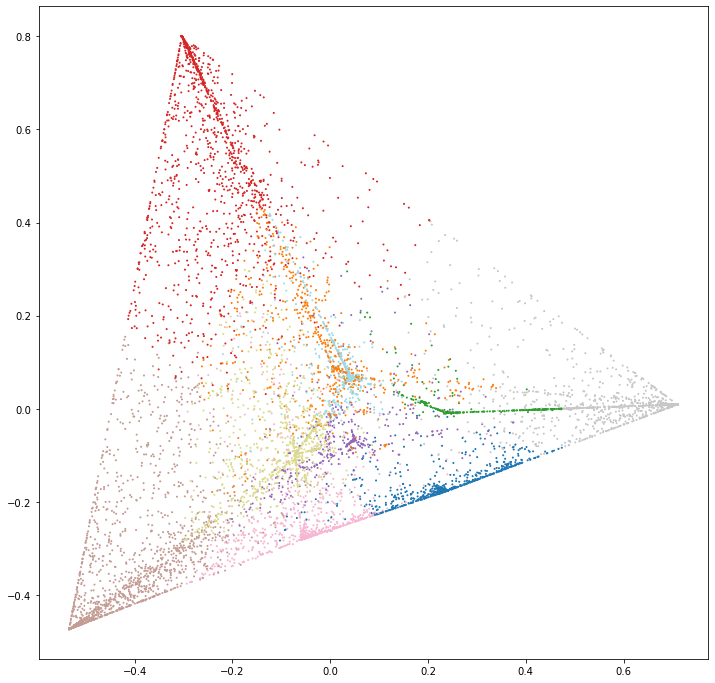

In [90]:
max_topic_id = book_representation.argmax(axis=1)
plt.figure(figsize=(12,12))
plt.scatter(pca_res[:,0], pca_res[:,1],s=1, c=max_topic_id,cmap = 'tab20')

In [39]:
book_popularity = df_ratings.groupby(['book_id'])[['book_id']].count()
book_popularity = book_popularity.rename(columns={'book_id': 'popularity'})
book_popularity.head()

,popularity
book_id,
0,22806
1,21850
10,12698
100,5199
1000,1327


In [40]:
df_books = df_books.merge(book_popularity, on='book_id', how='left')
df_books .head()

,book_id,authors,original_publication_year,original_title,language_code,popularity
0,0,Suzanne Collins,2008.0,The Hunger Games,eng,22806
1,1,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,21850
2,2,Stephenie Meyer,2005.0,Twilight,en-US,16931
3,3,Harper Lee,1960.0,To Kill a Mockingbird,eng,19088
4,4,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,16604


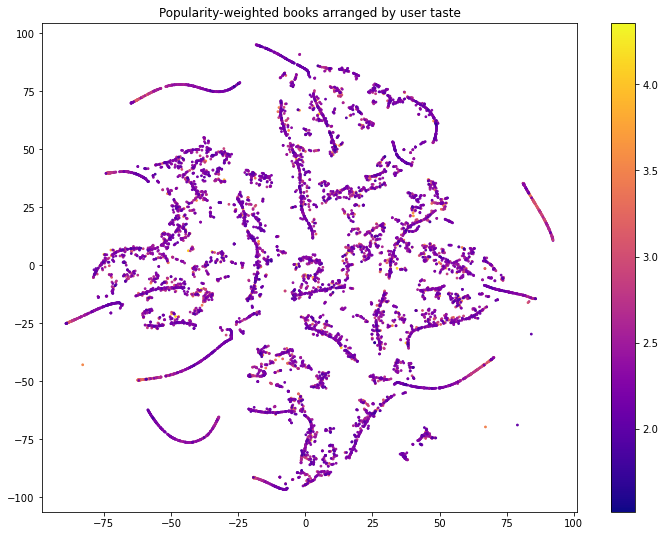

In [66]:
plt.figure(figsize=(12,9))

plt.scatter(tsne_cooordinates[:,0],tsne_cooordinates[:,1],s=3, c=np.log10(df_books['popularity'].values), cmap='plasma');
plt.title('Popularity-weighted books arranged by user taste')
plt.colorbar()


## whether the user tastes are grouped into distinct clusters:

## I couldnt get any user group from the data even the topic as we will see later didnt give me any indicator. I think the features that we have are not enough.

## Trying to exract the topics:

In [46]:
## Download nltk stopword incase you don't have already
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Majdal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
pip install pyLDAvis

In [49]:
import gensim, spacy
import gensim.corpora as corpora
from nltk.corpus import stopwords

import pandas as pd
import re
from tqdm import tqdm
import time


## Setup nlp for spacy
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = stopwords.words('english')
# Add some extra words in it if required
stop_words.extend(['from', 'subject', 'use','pron'])

In [51]:
# Convert into list
data = df_books.original_title.values.tolist()

In [52]:
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string 

# import numpy for matrix operation
import numpy as np

# Importing Gensim
import gensim
from gensim import corpora
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')
nlp = spacy.load('en_core_web_sm')

In [53]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Majdal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
stop=set(stopwords.words('english'))
exclist=set(string.punctuation + string.digits)
lemma=WordNetLemmatizer()

def clean(doc):
    stop_free=" ".join([i for i in doc.lower().split() if i not in stop])
    punc_free= ''.join(x for x in stop_free if x not in exclist)
    normlized=" ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normlized


In [55]:
clean_corpus=[clean(doc).split() for doc in data]

In [56]:
clean_corpus[0]

['hunger', 'game']

In [57]:
clean_corpus[-1]

['first', 'world', 'war']

In [61]:
clean_corpus[-300]

['star', 'war', 'lost', 'star']

In [62]:
# Creating the term dictionary of our courpus that is of all the words (Sepcific to Genism syntax perspective), 
# where every unique term is assigned an index. 

dict_ = corpora.Dictionary(clean_corpus)

print(dict_)

Dictionary(8418 unique tokens: ['game', 'hunger', 'harry', 'philosopher', 'potter']...)


In [63]:
# The dictionary had 8418 unqiue words in the cleaned corpus.
for i in dict_.values():
    print(i)

game
hunger
harry
philosopher
potter
stone
twilight
kill
mockingbird
gatsby
great
fault
star
back
hobbit
catcher
rye
angel
demon
prejudice
pride
kite
runner
divergent
eightyfour
nineteen
animal
fairy
farm
story
achterhuis
augustus
dagboekbrieven
het
juni
hatar
kvinnor
män
som
catching
fire
azkaban
prisoner
fellowship
ring
mockingjay
order
phoenix
bone
lovely
chamber
secret
goblet
deathly
hallows
code
da
vinci
halfblood
prince
fly
lord
conceited
excellent
juliet
romeo
tragedie
girl
gone
help
men
mouse
geisha
memoir
fifty
grey
shade
alquimista
giver
lion
wardrobe
witch
time
traveler
wife
throne
across
eat
everything
india
indonesia
italy
love
one
pray
search
woman
lightning
thief
little
eyre
jane
notebook
life
pi
elephant
water
book
fahrenheit
moon
new
drawing
end
poem
shel
sidewalk
silverstein
city
eclipse
eragon
galaxy
guide
hitchhiker
brave
world
breaking
dawn
bee
adventure
finn
huckleberry
charlotte
web
curious
dog
incident
nighttime
train
light
northern
height
wuthering
keeper
siste

second
tanner
cedar
falling
root
joke
invisible
long
soldier
frisby
nimh
rat
different
season
collection
fishing
hunting
omnibus
wool
biff
childhood
christ
gospel
pal
a
happened
mostly
pretend
lamora
locke
sabriel
storyteller
obsidian
crown
pilgrim
precious
scott
volume
broke
half
mort
fey
iron
the
dove
lonesome
cadaver
stiff
bloodline
twenty
ark
schindlers
bluest
autobiography
malcolm
x
nocturne
prelude
seabiscuit
shutter
caesar
julius
hitler
terror
πολιτεία
shrew
taming
cress
kid
j
jemima
notredame
balance
fine
calvin
hobbes
special
hunted
clear
danger
say
sht
trainspotting
agreement
practical
toltec
wisdom
brüder
grimm
hausmärchen
kinder
und
basil
e
file
frankweiler
mixedup
doctor
dublin
street
crazy
overwhelmed
relentless
fish
watcher
leave
abraham
hunter
フルーツバスケット
tempest
burned
circle
cabret
hugo
revisited
worldbrave
桜蘭高校ホスト部
far
too
landline
tempted
country
hall
wolf
howl
moving
dreamcatcher
walden
remains
best
ending
alibi
οἰδίπους
τύραννος
shanghai
willow
loved
persepolis
view

noexcuses
pawn
lake
beer
hell
serve
kokkyō
minami
nishi
taiyō
国境の南、太陽の西
usher
harriet
guest
paying
private
beginner
sushi
watermelon
den
komma
låt
rätte
highest
utmost
wee
written
nightshade
drachenreiter
teatime
uprooted
seveneves
armada
desert
spear
suit
summons
endurance
incredible
shackletons
heather
size
reach
bonfire
event
nile
shiloh
siege
rødstrupe
hide
seek
goodnight
nobody
start
worrying
breathe
instrument
tomorrow
escher
grafiek
mc
tekeningen
joan
pope
birdsong
moonwalking
remembering
science
july
paradox
itchy
bitterblue
everywhere
wyrd
real
nosa
tenant
wildfell
stallion
reckless
grim
grotto
nona
strega
playing
artmaking
observation
reward
frida
kahlo
bitten
bus
pigeon
wallpaper
yellow
هيبتا
anniversary
dreamland
forger
austenland
center
gilead
demonglass
ubik
shannara
hannibal
wish
knee
scorpio
morning
mossflower
furiously
happy
sugar
riftwar
neglected
remembered
redshirts
sahara
foot
fearless
fourteen
ambition
corruption
revolution
paddington
flawless
quimby
general
hospi

robber
thre
leopolds
notsotalented
habibi
silk
deity
brazil
interesting
sandcastle
fixed
manga
maximum
boyfriend
drengen
kufferten
publicly
shamed
you’ve
συμπόσιον
vernon
otherwise
sheila
colored
considered
enuf
micah
twice
precinct
cove
lizard
lust
melancholy
lisa
mona
overdrive
cay
addict
anonymous
fornemmelse
frøken
smillas
sne
shakespeare
stage
jumper
victory
hare
chameleon
thumb
starter
pedro
páramo
ingleside
middle
viscount
drown
nesmrtelnost
kept
ヘルシング
harvest
physician
dinosaur
rin
sho
五輪書
ticktock
icarus
nietzsche
wept
νικομάχεια
ἠθικὰ
tackle
daddy
berenstain
messy
blaze
karanda
dame
ディー・エヌ・エンジェル
matterhorn
vietnam
perilous
cronicle
fift
politics
nachfolge
moscow
colorblindness
incarceration
jim
mass
sult
unknown
burglar
joker
дозор
ночной
dept
speculation
charmed
santini
johnny
planète
singe
evergreen
experiencing
workbook
dragonsinger
boundless
whistler
dgrayman
closer
mix
tape
punk
uncensored
harlequin
elfów
krew
altar
clonmel
fireman
revenge
benhur
catalonia
homage
misguid

aquitaine
progression
forsyte
appelsinpiken
absurdistan
invincible
napalm
putty
silly
farsi
iranian
torturer
foxglove
sophy
serfdom
enlistment
tar
balloon
busyness
intimacy
ava
lavender
sacajawea
rift
foo
thump
engagement
ralph
creed
believing
bicycle
watersong
carrion
crispin
wielding
honour
raft
rue
australia
iraqare
japan
loses
popular
soccernomics
turkeyand
sapphique
meatless
birthright
peacegiver
cod
feminine
mystique
brighton
بابا
كخه
يا
afghanistan
promoting
departure
pastoralia
defining
matterand
methuselah
hana
acoming
eluria
outside
fact
fascinating
damnation
lignorance
استمتع
بحياتك
salvation
staying
bonjour
tristesse
cometh
bröderna
lejonhjärta
loyalty
quarry
beaker
tracy
lab
amadeus
lyon
eventually
bombshell
slated
bumi
manusia
stair
jaskółki
wieża
conqueror
デッドマン・ワンダーランド
bloodletters
christopher
fevre
frosting
speedy
goldfinger
nana
elgen
cabal
abstinence
typist
alien
sentry
sempre
mariana
solo
clementine
possum
log
mannen
else
everybody
overrated
performer
talent
worldcl

In [66]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary 
doc_term_matrix = [dict_.doc2bow(i) for i in clean_corpus]
doc_term_matrix[0:10]

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1)],
 [(7, 1), (8, 1)],
 [(9, 1), (10, 1)],
 [(11, 1), (12, 1)],
 [(13, 1), (14, 1)],
 [(15, 1), (16, 1)],
 [(17, 1), (18, 1)],
 [(19, 1), (20, 1)]]

In [67]:
# Creating the object for LDA model using gensim library

Lda = gensim.models.ldamodel.LdaModel

In [68]:
# Running and Training LDA model on the document term matrix.

ldamodel = Lda(doc_term_matrix, num_topics=6, id2word = dict_, passes=1, random_state=0, eval_every=None)

In [69]:
# Prints the topics with the indexes: 0,1,2,4,5:

ldamodel.print_topics()

# we need to manually check whethere the topics are different from one another or not

[(0,
  '0.012*"new" + 0.009*"first" + 0.009*"bone" + 0.009*"world" + 0.009*"lady" + 0.007*"la" + 0.007*"child" + 0.007*"queen" + 0.007*"black" + 0.006*"midnight"'),
 (1,
  '0.029*"life" + 0.014*"time" + 0.013*"house" + 0.010*"man" + 0.010*"shadow" + 0.010*"tale" + 0.009*"novel" + 0.009*"le" + 0.007*"heart" + 0.006*"star"'),
 (2,
  '0.018*"girl" + 0.014*"de" + 0.011*"dark" + 0.009*"dead" + 0.008*"year" + 0.007*"la" + 0.007*"die" + 0.006*"summer" + 0.006*"magic" + 0.006*"der"'),
 (3,
  '0.012*"day" + 0.011*"the" + 0.011*"vol" + 0.009*"story" + 0.008*"king" + 0.008*"good" + 0.008*"blood" + 0.007*"kiss" + 0.006*"lost" + 0.006*"soul"'),
 (4,
  '0.021*"death" + 0.014*"secret" + 0.010*"war" + 0.009*"fire" + 0.008*"blue" + 0.008*"daughter" + 0.007*"street" + 0.007*"world" + 0.006*"thing" + 0.006*"winter"'),
 (5,
  '0.020*"love" + 0.018*"one" + 0.016*"story" + 0.014*"night" + 0.011*"little" + 0.010*"last" + 0.008*"dream" + 0.008*"power" + 0.008*"city" + 0.007*"world"')]

## In which ways could these tools be used to improve performance of an online bookstore?

##  These tools can record user behavior (view, like or not, collect, buy and so on) and user generated content with cookie technique, which makes it easier to evaluate customers’ preferences on firm’s products or services.As a result, It braught more profit for retailers and provided personalized service for customers.